# Snapchat Political Ads
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings

Prediction: We will try to predict the reach, or the number of views, of an ad. This is a regression problem. 
### Introduction
TODO

### Baseline Model
OneHotEncoder is ideal, because we use easily use it on all of the categorical columns. The function of OHE is to "Encode categorical features as a one-hot numeric array", so we can have numerical values onto the qualitiative values for easy calculations and predictions within the data. For both numerical and categorical columns, we used Simple Imputer in case there were any missing values that we had missed. 

Since it is just a baseline model, we did not focus on separating between nominal or ordinal columns because we end up dropping a lot of the columns later in our final model. But we don't differentiate it in our final model either, because we only use either quantitative or nominal data. 

r-squared: //TODO

rmse: //TODO

Based on the evaluation metric as well as referencing our pipeline, we anticipate the baseline model to not be a very good predictor of the number of views. The OHE wthin the categorical columns is decent, but it does not do anything within the quantitative columns except impute it with a neutral value of 0, which can possibly bias the columns in the direction that we don't want to go in. 
### Final Model
Impressions, Duration, and Spend are our quantitative columns. StartDate, EndDate, Gender, CountryCode, and spending_brackets are our qualitative columns, but more specifically, our nominal data. We are not working with any ordinal data. Although StartDate and EndDate may be a bit blurry on the classification of being nominal or ordinal, we have categorized these two columns as nominal, which is explained in a bit more detail later. We chose to work with these columns specifically because we considered these to contain the most valuable information. StartDate and EndDate might be significant, concerning the exact time of year that the ad was being displayed. For example, if it was aired durig the holiday season, there might be more impressions because more people are out of school, on vacation and not working, etc. As for gender, if there were restrictions on one gender, it cuts off half the general population, which will likely greatly reduce the amount of views an ad has. For CountryCode, there are vastly different population numbers varying by country. The US may have way more impressions than a smaller and less populated country, like Korea for example. It also brings into context that many people around the world may not utilize Snapchat as one of their main sources of social media- in other words, Snapchat may not be as popular in other countries as it is in the United States. As for our newly engineered features and why we believe they are vital to our predictions, they are discussed later within our code. 

In addition to the functions that we used within our baseline model, we also included PCA onto our categorical columns as well as QuantileTransformer within our numerical columns. 
PCA is significant in increasing our accuracy of our predictions because it is able to project the values within the categorical columns into a lower dimensional space if needed by using Singular Value Decomposition (SVD). This can be especially important, especially to centralize the values coming from the categorical columns, even if we ourselves may not necessarily see it. As for QuantileTransformer, it allows the numerical columns to follow a bell curved shape. 

We had set our baseline to a LinearRegression model, but later progressed to using a RandomForestRegressor because we thought that this would work better than a LinearRegression model because it is able to use the averages of our features to be able to produce better predictions. Another plus is that it is able to control, to some extent, over-fitting, which was an issue we were worried about. 


r-squared: //TODO

rmse: //TODO

The feature that ended up performing the best was //TODO 
### Fairness Evaluation
TODO

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import re
from sklearn import metrics
import datetime as dt 
from sklearn.preprocessing import QuantileTransformer


In [2]:
eighteen = pd.read_csv("2018.csv")
nineteen = pd.read_csv("2019.csv")
result = pd.concat([eighteen, nineteen])
result = result.reset_index(drop=True)
dates = result[['StartDate', 'EndDate', 'CreativeUrl']]
result.columns

Index(['ADID', 'CreativeUrl', 'Spend', 'Impressions', 'StartDate', 'EndDate',
       'OrganizationName', 'BillingAddress', 'CandidateBallotInformation',
       'PayingAdvertiserName', 'Gender', 'AgeBracket', 'CountryCode',
       'RegionID', 'ElectoralDistrictID', 'LatLongRad', 'MetroID', 'Interests',
       'OsType', 'Segments', 'LocationType', 'Language',
       'AdvancedDemographics', 'Targeting Connection Type',
       'Targeting Carrier (ISP)', 'Targeting Geo - Postal Code',
       'CreativeProperties'],
      dtype='object')

Prediction: We will try to predict the reach, or the number of views, of an ad. This is a regression problem. 

### Baseline Model

In [3]:
# changing all dates to datetime objects
result['StartDate'] = result['StartDate'].str[:-1]
result['EndDate'] = result['EndDate'].str[:-1]

# StartDate = pd.to_datetime(result['StartDate'])
# result['EndDate'] = pd.to_datetime(result['EndDate'], errors='coerce')

# Segments
result['Segments'] = result['Segments'].fillna("Not Provided by Advertiser")

# these cols need to all be filled nans with the respective country
country_cols = ["RegionID", "ElectoralDistrictID","LatLongRad","MetroID","Targeting Geo - Postal Code"]

for i in range(len(country_cols)):
    result[country_cols[i]] = result[country_cols[i]].fillna(result["CountryCode"])

# these cols need to all be filled nans with just string "all"
all_cols = ["Interests","Language","AdvancedDemographics","Gender","AgeBracket","OsType"]
    
for i in range(len(all_cols)):
    result[all_cols[i]] = result[all_cols[i]].fillna("All")
    
nan_cols = ['CandidateBallotInformation', 'LocationType', 'CreativeProperties']
for i in range(len(nan_cols)): 
    result[nan_cols[i]] = result[nan_cols[i]].fillna("Not provided")
    
# EndDate                         fill with "Present" or current time
result['EndDate'] = str(result['EndDate'].fillna(datetime.utcnow()))
# Gender                          fill with "All"
result['Gender'] = result['Gender'].fillna("All")
result = result.drop(columns=['Targeting Connection Type', "Targeting Carrier (ISP)"])
#CandidateBallotInformation; LocationType; Creative Properties

In [4]:
X = result.drop(['Impressions'], axis=1)
y = result.Impressions

In [5]:
#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([('numcols', SimpleImputer(strategy='constant', fill_value="null")),
                 ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
                 ])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols) #pipeline for numerical columns 
])

pl = Pipeline([('feats', ct), ('reg', LinearRegression())])

#getting the mean of rmse and r^2 after 50 iterations 
rmse_list = []
rsquared_list = []
for i in range(10): 
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    rsquared = pl.score(X_ts, y_ts)
    rsquared_list.append(rsquared)
    preds = pl.predict(X_ts)
    rmse = np.sqrt(np.mean(preds - y_ts)**2)
    rmse_list.append(rmse)
print("rmse mean: " + str(np.mean(rmse_list)))
print("r-squared mean: " + str(np.mean(rsquared_list)))

rmse mean: 28457.011546722828
r-squared mean: 0.6560792028684438


### Final Model

In [6]:
#setting StartDate and EndDate to datetime objects so we can calculate a new feature, Duration 
dates['StartDate'] = pd.to_datetime(dates['StartDate'])
dates['EndDate'] = pd.to_datetime(dates['EndDate'], errors='coerce')
dates['EndDate'] = dates['EndDate'].fillna(datetime.utcnow())

In [7]:
#New feature: Duration 
result['Duration'] = abs(dates['EndDate'] - dates['StartDate'])
result["Duration"] = round(result['Duration'].apply(lambda x: x.days * 24 + x.seconds // 3600))

We created a new feature, Duration, which is the time in hours, the ad was aired on Snapchat. We categorized StartDate and EndDate as nominal categories, as we believe it represents no ordering. But by being able to subtract the EndDate and the StartDate, we can develop values that do have specific orderings to them; e.g. ads that aired for 5 hours is definitely shorter than ones that aired for 25 hours. But this new column, Duration, is a good addition to our features because it is a quantitative column as it is numbers that we can do mathematical applications with, e.g. mean, median, quartiles, etc. 

In [8]:
#the columns we're working with 
result = result[['Impressions', 'StartDate', 'EndDate', 'Duration', 'Spend', 'Gender', 'CountryCode']]

#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    #pipeline for numerical columns
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols),
    ('quantiles', QuantileTransformer(), numcols)

])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.6693135844085638
rmse: 30882.909306569352


In [9]:
result['Spend'].max()

85000

Text(0.5, 0, 'Spend')

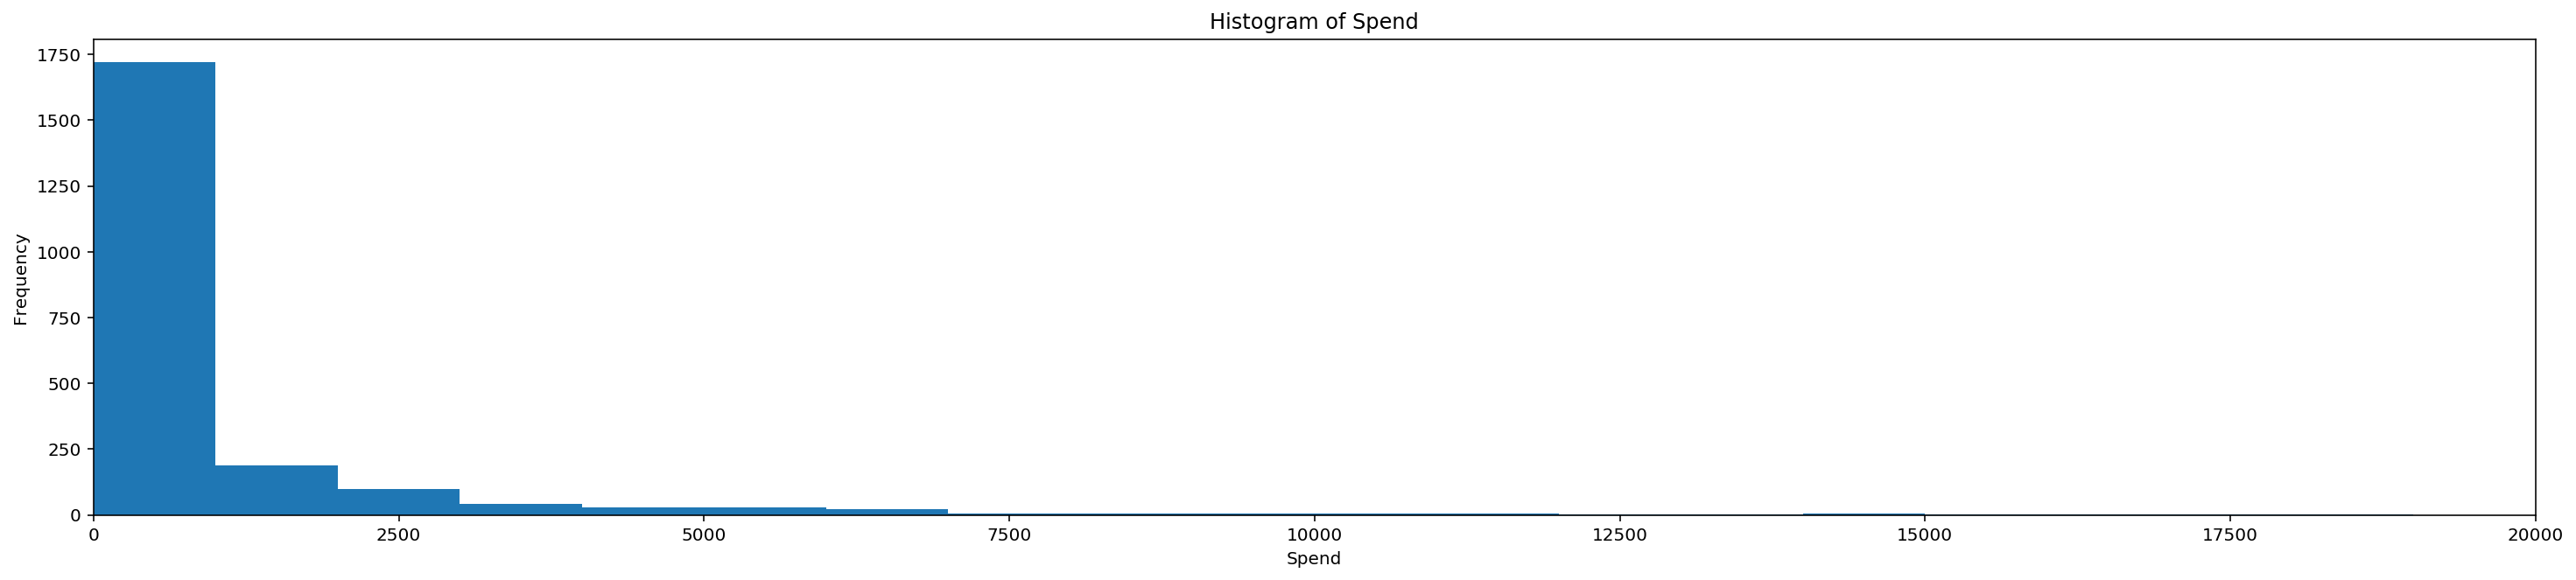

In [10]:
result["Spend"].plot(kind='hist', bins=85,figsize=(25,5), xlim=(0,20000))
plt.title('Histogram of Spend')
plt.xlabel('Spend')

We can tell that 1000 is where a majority of the ad spending is concentrated on because we have set the number of bins to 85, and since the max amount spent on an ad is 85,000, we know that each bin is roughly at around 1,000. So, we decided to make the cutoff for high and low spending to be at $1000. 

In [11]:
#New feature: High or low spending 
result['spending_brackets'] = (result.Spend <= 1000).replace({True:'Low', False:'High'})

We created a new feature called spending_brackets. This is a binary column, in which we have categorized what a 'high' or 'low' spending is. We were able to define this threshold by graphing the distribution (the histogram above). By having a feature with a more definitive answer on what we consider a high or low spending value, we believe this will enhance our predictions. 

In [12]:
#columns we're working with 
result = result[['Impressions', 'StartDate', 'EndDate', 'spending_brackets', 'Spend','Gender', 'CountryCode']]

#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    #pipeline for numerical columns
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols),
    ('quantiles', QuantileTransformer(), numcols)

])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.504297359709582
rmse: 36209.4377737226


### Final Model with New Features

In [13]:
#New feature: Duration 
result['Duration'] = abs(dates['EndDate'] - dates['StartDate'])
result["Duration"] = round(result['Duration'].apply(lambda x: x.days * 24 + x.seconds // 3600))

#New feature: Media Type
result['spending_brackets'] = (result.Spend <= 1000).replace({True:'Low', False:'High'})

In [14]:
#columns we're working with 
result = result[['Impressions', 'StartDate', 'EndDate', 'Duration', 'spending_brackets', 'Spend','Gender', 'CountryCode']]

#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    #pipeline for numerical columns
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols),
    ('quantiles', QuantileTransformer(), numcols)

])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

rmse_list = []
rsquared_list = []
for i in range(10): 
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl2.fit(X_tr, y_tr)
    rsquared = pl2.score(X_ts, y_ts)
    rsquared_list.append(rsquared)
    preds = pl2.predict(X_ts)
    rmse = np.sqrt(np.mean(preds - y_ts)**2)
    rmse_list.append(rmse)
print("rmse mean: " + str(np.mean(rmse_list)))
print("r-squared mean: " + str(np.mean(rsquared_list)))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rmse mean: 76517.18764598538
r-squared mean: 0.5801023066000912


### Fairness Evaluation

### Permutation Testing

In [15]:
#RMSE fairness evaluation
low_list = []
high_list = []

for i in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl2.fit(X_tr, y_tr)
    preds = pl2.predict(X_ts)

    results = pd.DataFrame()

    results["Observed"] = y_ts
    results["Prediction"] = preds
    results['High_or_Low'] = (results.Observed <= 3130994.5).replace({True:'Low', False:'High'})
    results = results[["High_or_Low", "Observed", "Prediction"]]

    high_df = results[results["High_or_Low"] == "High"]
    high_rmse = np.sqrt(np.mean(high_df["Prediction"] - high_df["Observed"])**2)
    high_list.append(high_rmse)

    low_df = results[results["High_or_Low"] == "Low"]
    low_rmse = np.sqrt(np.mean(low_df["Prediction"] - low_df["Observed"])**2)
    low_list.append(low_rmse)

#test stat = rmse
# null the high list performs better than the low list
np.count_nonzero(low_list >= high_list) / 100 # count how many times the low list does better than the high
# pval = 0, 100% of the time the high list performs worse than the low list, reject the null hyp

# low_list, high_list

SyntaxError: invalid character in identifier (<ipython-input-15-fde5050b1ed2>, line 6)